# 1. Install Dependencies and Setup

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!pip list

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [ ]:
import cv2
import imghdr

<ipython-input-7-290956b76b78>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/data'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
tf.keras.utils.image_dataset_from_directory??


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 305 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()


In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
len(batch)

2

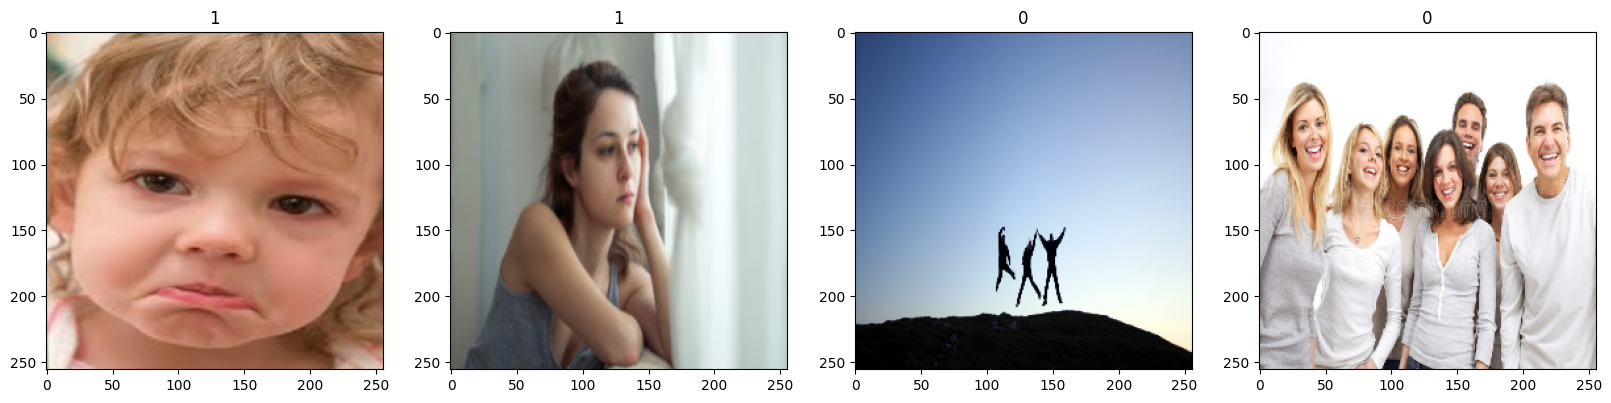

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
#print("Vraies étiquettes :", batch[1][:4].numpy())  # Vérifiez si les labels sont bien 0 (Happy) et 1 (Sad)
print("Vraies étiquettes :", batch[1][:4])


Vraies étiquettes : [1 1 0 0]


# 4. Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

(array([[[[2.58823544e-01, 3.68627459e-01, 7.84313753e-02],
          [2.52115101e-01, 3.54075879e-01, 6.78013787e-02],
          [2.31771499e-01, 3.33732277e-01, 5.53009026e-02],
          ...,
          [9.22241986e-01, 9.61457670e-01, 6.80881679e-01],
          [9.20129836e-01, 9.61980283e-01, 6.56699896e-01],
          [9.16884065e-01, 9.52178180e-01, 6.32677555e-01]],
 
         [[2.58823544e-01, 3.68627459e-01, 7.84313753e-02],
          [2.49299586e-01, 3.51260364e-01, 6.49858639e-02],
          [2.28835344e-01, 3.30796123e-01, 5.23647517e-02],
          ...,
          [9.27198231e-01, 9.64393854e-01, 6.94939196e-01],
          [9.19638455e-01, 9.61488962e-01, 6.60232842e-01],
          [9.13725495e-01, 9.51799929e-01, 6.17968738e-01]],
 
         [[2.54365146e-01, 3.64169061e-01, 7.39729926e-02],
          [2.43068323e-01, 3.45029116e-01, 5.87545969e-02],
          [2.27450982e-01, 3.29411775e-01, 5.09803928e-02],
          ...,
          [9.33490872e-01, 9.68072712e-01, 7.2191

# 5. Split Data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

7

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#!pip install tensorflow


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4985 - loss: 1.1963 - val_accuracy: 0.5156 - val_loss: 0.6736
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6099 - loss: 0.6374 - val_accuracy: 0.5781 - val_loss: 0.6243
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.6788 - loss: 0.6156 - val_accuracy: 0.7344 - val_loss: 0.5860
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7689 - loss: 0.5674 - val_accuracy: 0.5625 - val_loss: 0.5894
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7857 - loss: 0.5084 - val_accuracy: 0.9062 - val_loss: 0.4000
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8170 - loss: 0.4325 - val_accuracy: 0.8281 - val_loss: 0.4283
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8298 - loss: 0.3920 - val_accuracy: 0.9375 - val_loss: 0.2515
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9493 - loss: 0.2450 - val_accuracy: 0.9531 - val_loss: 0.1431
Epoch 9/

# 8. Plot Performance

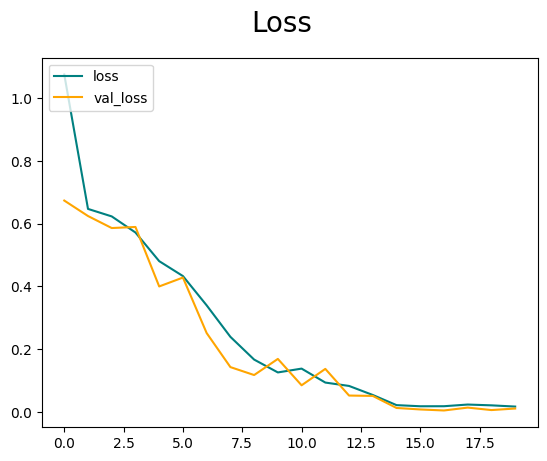

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

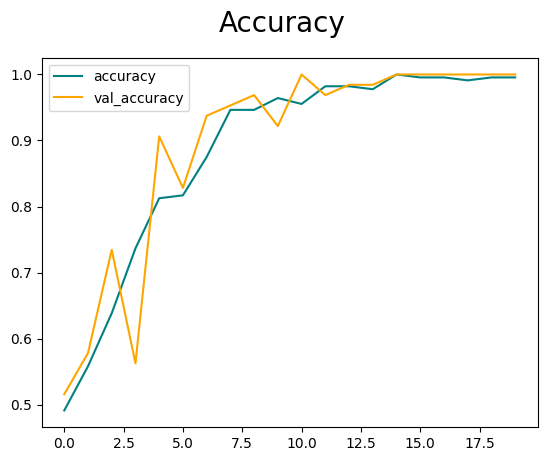

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.8, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


In [ ]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())


1.0 0.8 0.9411765


# 10. Test

In [ ]:
import cv2

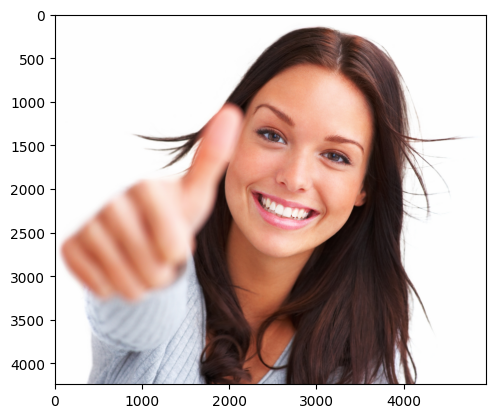

In [ ]:
#img = cv2.imread('154006829.jpg')
img = cv2.imread('/content/gdrive/MyDrive/ImageClassification/happy.jpg')
#plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

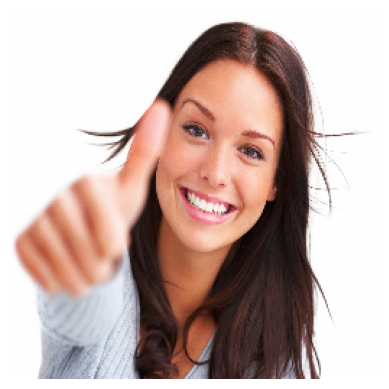

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionner l'image avec TensorFlow
resize = tf.image.resize(img, (256, 256))

# Afficher correctement l'image
plt.imshow(resize.numpy().astype("uint8"))  # Utiliser "uint8" pour éviter des erreurs d'affichage
plt.axis("off")  # Supprimer les axes pour un meilleur rendu
plt.show()

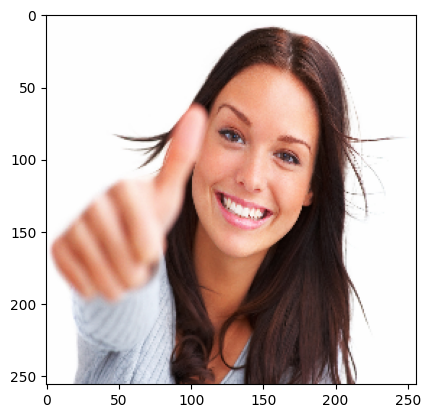

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype("uint8"))
plt.show()

In [ ]:
resize.shape

TensorShape([256, 256, 3])

In [ ]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [ ]:
yhat

array([[0.06654256]], dtype=float32)

In [ ]:
#yhat = model.predict(batch[0][:4])  # Prédictions sur 4 images
#print("Prédictions brutes :", yhat.flatten())  # Afficher les scores entre 0 et 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Prédictions brutes : [9.8218071e-01 8.2992810e-01 1.2263414e-05 4.2274414e-04]


In [ ]:
#  for idx, score in enumerate(yhat.flatten()):
#      predicted_class = "Sad" if score > 0.5 else "Happy"
#      print(f"Image {idx+1} : Score={score:.4f} → Prédiction : {predicted_class}")


In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Sauvegarde du modèle dans Google Drive
model.save("/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/imageclassifier.keras")


In [ ]:
new_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/ImageClassification/imageclassifier.keras')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


array([[0.06654256]], dtype=float32)